# Выбор локации для скважины


Предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Необходимо построить модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Требуется проанализировать возможную прибыль и риски техникой *Bootstrap.*

Настоящее исследование подразумевает выполнение следующих шагов:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

## Загрузка и подготовка данных

In [1]:
# импортируем необходимые библиотеки
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [2]:
# загрузим в соответствующие переменные данные из трех регионов претендентов на открытие скважины
geo_0 = pd.read_csv('/datasets/geo_data_0.csv')
geo_1 = pd.read_csv('/datasets/geo_data_1.csv')
geo_2 = pd.read_csv('/datasets/geo_data_2.csv')

### Ознакомление с данными

Стуктуры трех датасетов идентичны, данные собраны для трех регионов по одной методике, поэтому можно дать общий обзор на примере данных только одного из регионов, например, geo_1:

In [3]:
# визуальный осмотр датасета
geo_1.sample(5)

,id,f0,f1,f2,product
34373,rdJeX,0.709363,-8.800175,0.997669,30.132364
9225,HW7et,-10.890456,-1.908382,3.001627,84.038886
71455,BKcwn,10.346354,-7.530732,-0.004061,0.000000
63567,zc8Ue,-8.304229,-7.789619,3.004747,84.038886
99285,hXzn0,-0.355643,-7.665861,1.986542,57.085625


- id — уникальный идентификатор скважины;
- f0, f1, f2 — три признака точек (обучающие признаки), характеристики скважин на основе значений которых строится предположение о запасах скважины;
- product — объём запасов в скважине тыс. баррелей (целевой признак)

In [4]:
# сводная информация для набора данных по geo_1
geo_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


Данные содержат информацию по 100000 замерам для каждого региона. Типы данных соответствуют измеряемым величинам, пропусков нет. Названия столбцов выдержаны в едином формате. В колонке 'id' содержится небольшое количество дубликатов:

In [5]:
# 4 дубликата в идентификаторах замеров для geo_1
geo_1.loc[geo_1['id'].duplicated()]

,id,f0,f1,f2,product
41906,LHZR0,-8.989672,-4.286607,2.009139,57.085625
82178,bfPNe,-6.202799,-4.820045,2.995107,84.038886
82873,wt4Uk,10.259972,-9.376355,4.994297,134.766305
84461,5ltQ6,18.213839,2.191999,3.993869,107.813044


In [6]:
# значения f0, f1, f3 различны для одинаковых id
geo_1.loc[geo_1['id']=='LHZR0']

,id,f0,f1,f2,product
1305,LHZR0,11.170835,-1.945066,3.002872,80.859783
41906,LHZR0,-8.989672,-4.286607,2.009139,57.085625


В данных остальных регионов также имеются дубликаты идентификаторов замеров (причем характеристики f0, f1, f2 этих дубликатов различны). Повторяющихся значений для geo_0 - 10шт, geo_2 - 4шт. Необходимо выяснить в компании причину возникновения таких повторов. Принимая во внимание их малое количество, а также тот факт, что характеристики скважин отличаются (то  есть это "неполный дубликат"), будем каждый каждый такой повтор считать уникальной записью.

In [7]:
# объединим таблицы регионов и проверим на пропуски. Пропуски отсутствуют
pd.concat([geo_0, geo_1, geo_2], axis=0).isnull().sum()

id         0
f0         0
f1         0
f2         0
product    0
dtype: int64

### Данные не учавствующие в обучении модели

In [8]:
# необходимо удалить из датасета идентификатор измерения - столбец "id", так как он 
# не несет никакого полезного сигнала для модели
geo_0 = geo_0.drop('id', axis=1)
geo_1 = geo_1.drop('id', axis=1)
geo_2 = geo_2.drop('id', axis=1)

### Масштабирование признаков

Признаками для обучения модели будут столбцы f0, f1, f2. Они принимают исключительно числовые значения. Посмотрим разброс этих значений.

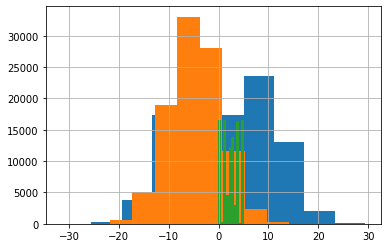

In [9]:
# оценим визуально разброс значений признаков f0, f1, f2
geo_1.f0.hist()
geo_1.f1.hist()
geo_1.f2.hist();

Заметно, что диапазоны значений различны и поэтому необходимо произвести масштабирование значений. Сделаем это с помощью стандартного инструмента из библиотеки sklearn StandardScaler(). На данном этапе создадим функцию Scaling().  Использовать ее будем после разбиения данных на обучающую и валидационную выборки.

In [10]:
# строка позволяющая избежать предупреждения SettingWithCopy
pd.options.mode.chained_assignment = None

In [11]:
# создадим объект структуры StandardScaler()
scaler = StandardScaler()

In [12]:
# функция принимает на вход два объекта DataFrame, в нашем случае это будут обучающие и валидационные данные
def scaling(train, valid):
    scaler.fit(train)  # на train данных обучаем scaler и
    # преобразуем признаки train и valid
    return pd.DataFrame(scaler.transform(train), columns=['f0', 'f1', 'f2']), \
           pd.DataFrame(scaler.transform(valid), columns=['f0', 'f1', 'f2'])

### Вывод

На данном этапе мы располагаем данными в объеме 100000 измерений для каждого из трех регионов. На основе этих данных нам предстоит создать модель, которая предсказывает запасы сырья. Для этих целей был отброшен неинформативный столбец "id". Предстоит масштабирование значений - для этого создан объект структуры StandardScaler(). Также мы убедились в отсутствии пропусков. Обнаружили неполные дубликаты, которые остаются в датсетах. Поскольку нам ничего не известно о критериях  f0, f1, f2, мы можем только предполагать какие значения должны принимать эти переменные, какие из них являются аномалией или выбегом - оставляем их как есть в датасете.

## Обучение и проверка модели

Создадим, обучим и посмотрим на результаты работы модели линейной регрессии для каждого из регионов. Обучающими признаками для нашей модели послужат столбцы f0, f1, f2. Целевым признаком - product:

In [13]:
# создадим список регионов
regions = [geo_0, geo_1, geo_2]

In [14]:
# переменные для хранения необходимых  в дальнейшем показателей и инструментов
models, rmse, predictions, targets, all_features = [],[],[],[],[]

 - models - хранит обученные модели линейной регрессии
 - rmse - значения квадратного корня из среднеквадратичного отклонения для каждой из моделей
 - predictions - значения запасов нефти предсказанное моделями
 - targets - реальные значения запасов нефти
 - all_features - обучающие признаки f0, f1, f2 для каждого региона
 
Все переменные это списки. Номер индекса элемента списка это номер региона.

In [15]:
# создадим функцию split(), выполняющую разбиение на обучающую и валидационную выборку
def split(features, target):
    return train_test_split(features, target, test_size=0.25, random_state=12345)

Создадим функцию predict_and_rmse(), которая заполняет описанные выше переменные, необходимые для дальнейших расчетов:

In [16]:
# функция predict_and_rmse() принимает на вход датасет, geo_0, geo_1, или geo_2
def predict_and_rmse(dataset):
# отделяет обучающие данные от целевого признака
    target = dataset['product']
    features = dataset.drop(['product'] , axis=1)
# делит на обучающую и валидационную выборки функцией split()
    features_train, features_valid, target_train, target_valid = split(features, target)
# масштабирует признаки функцией scaling()
    features_train, features_valid = scaling(features_train, features_valid)      
# обучает модель
    model = LinearRegression()
    model.fit(features_train, target_train)
# делает предсказания
    predicted_valid = model.predict(features_valid)
# оценивает качество предсказания
    mse = mean_squared_error(target_valid, predicted_valid)
# возвращает model, rmse для model, предсказания, целевой признак и признаки выборки valid для каждого региона
    models.append(model)
    rmse.append(mse**.5)
    predictions.append(predicted_valid)
    targets.append(target_valid)
    all_features.append(features_valid)

In [17]:
# передадим на вход функции predict_and_rmse() данные каждого из регионов
for region in regions:
    predict_and_rmse(region)

Выведем на экран результаты работы модели - предсказанный средний объем запасов сырья и квадратный корень из средней квадратичной ошибки для каждого из 3-х регионов:

In [18]:
# средний запас предсказанного сырья и RMSE для трех регионов
for i in range(len(regions)):
    mean = predictions[i].mean()
    print('Регион', i)
    print(f'Средний объем запасов сырья: {mean:.2f} тыс. баррелей')
    print("RMSE модели: ", round(rmse[i],4), "тыс. баррелей")
    print()

Регион 0
Средний объем запасов сырья: 92.59 тыс. баррелей
RMSE модели:  37.5794 тыс. баррелей

Регион 1
Средний объем запасов сырья: 68.73 тыс. баррелей
RMSE модели:  0.8931 тыс. баррелей

Регион 2
Средний объем запасов сырья: 94.97 тыс. баррелей
RMSE модели:  40.0297 тыс. баррелей



### Вывод

Мы подготовили данные для расчетов, создали модель линейной регрессии для каждого региона и обучили ее. Значения RMSE для региона 1 много меньше значений отклонений остальных регионов - это говорит о том, что показаниям из данного региона стоит доверять больше.

На следующем шаге, подготовим данные для расчета прибыли и риска убытков для каждого из регионов.

## Подготовка к расчёту прибыли

Для расчета прибыли нам понадобятся следующие переменные:

In [19]:
# бюджет на разработку месторождения в одном регионе 10 млрд.руб
BUDGET = 1e10
# стоимость барреля 450 руб.
BARREL = 450
# создадим переменную state через которую будем передавать формируемым выборкам случайное значение для random_state
state = np.random.RandomState(12345)

Перед созданием функции для вычисления прибыли, найдем точку безубыточности. В денежном выражении она составляет  10млрд. руб. на регион, или 50млн.руб на каждую из 200 скважин. Исходя из того, что рыночная цена составляет 450 руб. за баррель, то для того чтобы отбить затраты и перейти к извлечению прибыли необходимо добыть 50 млн.руб/ 450 руб = 111111 баррелей с одной скважины или 22222222 баррелей с 200 скважин по всему региону. Это значения точки безубыточности в натуральном выражении.

Создадим функцию для вычисления прибыли income(). Функция принимает набор из двухсот значений. Каждое значение это запас нефти в одной из двухсот скважин для одного из трех регионов. Чтобы подсчитать прибыль для региона, нужно сложить все 200 значений, умножить на стоимость барреля нефти (переменная BARREL) и вычесть из полученного произведения затраты связанные с разведкой, разработкой и обслуживанием месторождения региона (переменная BUDGET). Функция возвращает сумму прибыли в рублях.

In [20]:
# функция для расчета прибыли
def income(dataset):
    return dataset.sum() * 1000 * BARREL - BUDGET

### Вывод

У нас есть необходимые данные, переменные, функции для расчетов. Создадим сводную функцию, позволяющую сделать окончательный вывод в пользу того или иного региона, что и является целью настоящего исследования

## Расчёт прибыли и рисков 

Чем удачней были выбраны точки для предполагаемых скважин (чем выше в них содержание нефти), тем выше возможная прибыль для каждого из рассматриваемых регионов. Попробуем оценить возможную прибыль для каждого из регионов техникой Bootstrap. 
* Будем случайным образом выбирать порцию данных по 500 записей  из списка predicts. Этот список содержит три набора данных по 25000 записей для каждого региона. Эти записи - предсказания нашей модели линейной регрессии (см. п.2).
* Выбрав 500 записей, отберем 200 записей с наибольшим показателем запасов нефти. Возьмем из переменной targets 200 записей с индексами, соответствующими индексам записей, отобранных нами ранее из переменной predictions. targets - это реальные данные. 
* Передав targets в качестве параметра в функцию income(), посчитаем прибыль и, таким образом, поймем сколько бы мы заработали на самом деле, выбрав текущую комбинацию 500 записей.
* Выполним 1000 таких итераций для каждого региона и получим распределение значений прибыли. На основе этих данных получим среднюю прибыль, построим 95% доверительный интервал и оценим риск убытков (отношение числа отрицательных значений прибыли к общему числу итераций). 
* Получив эти значения можно будет сделать выбор в пользу одного из регионов.

In [21]:
# функция для оценки прибыльности и риска убытков
def mean_income_risk(targts, feature, model):
    values = []
    # используя обученную ранее модель делаем предсказания
    predicts = model.predict(feature)
    # преобразуем входные данные в объект pd.Series и присвоим объекту одинаковые индексы
    targts = pd.Series(targts).reset_index(drop=True)
    predicts = pd.Series(predicts).reset_index(drop=True)
    # bootstrap
    for i in range(1000):
        # 500 записей из предсказаний модели
        predicts_subsample = predicts.sample(n=500, replace=True, random_state=state)
        # из предсказанных значений выбираем 200 лучших
        predicts_subsample200 = predicts_subsample.sort_values(ascending=False)[:200]
        # соответствующие им записи из реальных значений
        targts_subsample = targts[predicts_subsample200.index]
        # сортируем по убыванию, берем первые 200 записей, функцией income()
        # считаем прибыль и добавляем это значение в values        
        values.append(income(targts_subsample)) 
    values = pd.Series(values)
    mean_income = values.mean() # средняя прибыль
    lower = values.quantile(0.025) # нижняя граница доверительного интервала
    upper = values.quantile(0.975) # верхняя граница доверительного интервала
    risk = (values <= 0).sum()/len(values) # оценка риска, доля неокупившихся скважин из общего числа скважин
    return mean_income, lower, upper, risk

In [22]:
# создадим список, в который поместим все необходимые характеристики регионов
key_values = []

In [23]:
# заполним key_values() и посмотрим на их значения
for i in range(len(regions)):
    key_values.append(mean_income_risk(targets[i], all_features[i], models[i]))

In [24]:
# рассмотрим key_values регионов
for i in range(len(regions)):
#    mean = predictions[i].mean()
    print('Регион', i)
    print(f'Средняя прибыль: {key_values[i][0]:.2f} руб')
    print(f'Наименьшая возможная прибыль: {key_values[i][1]:.2f} руб')
    print(f'Наибольшая возможная прибыль: {key_values[i][2]:.2f} руб')
    print(f'Риск понести убыток: {(key_values[i][3])*100:.1f} %')
    print()

Регион 0
Средняя прибыль: 396164984.80 руб
Наименьшая возможная прибыль: -111215545.89 руб
Наибольшая возможная прибыль: 909766941.55 руб
Риск понести убыток: 6.9 %

Регион 1
Средняя прибыль: 461155817.28 руб
Наименьшая возможная прибыль: 78050810.75 руб
Наибольшая возможная прибыль: 862952060.26 руб
Риск понести убыток: 0.7 %

Регион 2
Средняя прибыль: 392950475.17 руб
Наименьшая возможная прибыль: -112227625.38 руб
Наибольшая возможная прибыль: 934562914.55 руб
Риск понести убыток: 6.5 %



## Общий вывод

Как видно из расчетных показателей, предпочтительным регионом для разработки месторождения оказался регион 1: среднее значение прибыли для него 461 млн.руб выше, чем у остальных регионов (396 и 393 млн.руб). И хотя регион 1 не превосходит регионы 0 и 2 по максимальному значению возможной прибыли, его риск убытка (0.7%) на порядок ниже рисков для этих регионов (6,9% и 6,5% соответственно).